针对每个symbol取固定rolling区间，计算每时刻主动买入的成交额占比

In [1]:
import polars as pl
import numpy as np

# 读取数据
data = pl.read_parquet("daily_data.pa")

df = data.sort('open_time').sort('symbol')

# 窗口大小
N = 15

df = df.with_columns([
    pl.col('taker_buy_quote_volume').rolling_sum(N,min_periods=1).over('symbol').alias('taker_buy_quote_volume_sum'),
    (pl.col('close') / (pl.col('close').shift(1).over('symbol')) - 1).alias('return')
])

df

open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,symbol,taker_buy_quote_volume_sum,return
datetime[μs],f64,f64,f64,f64,f64,datetime[μs],f64,i64,f64,f64,str,f64,f64
2023-11-22 00:00:00,0.00478,0.004825,0.004076,0.004531,1.2701e10,2023-11-22 23:59:59.999,5.6368e7,320715,6.1849e9,2.7467e7,"""1000BONKUSDT""",2.7467e7,null
2023-11-23 00:00:00,0.004531,0.004858,0.00393,0.004267,1.8971e10,2023-11-23 23:59:59.999,8.1590e7,573386,8.8982e9,3.8318e7,"""1000BONKUSDT""",6.5785e7,-0.058265
2023-11-24 00:00:00,0.004267,0.004335,0.003835,0.00414,1.7169e10,2023-11-24 23:59:59.999,6.9929e7,475254,7.9410e9,3.2393e7,"""1000BONKUSDT""",9.8178e7,-0.029763
2023-11-25 00:00:00,0.004143,0.0046,0.004084,0.00434,1.3093e10,2023-11-25 23:59:59.999,5.6988e7,501832,6.3891e9,2.7819e7,"""1000BONKUSDT""",1.2600e8,0.048309
2023-11-26 00:00:00,0.004341,0.004473,0.0039,0.004039,8.2273e9,2023-11-26 23:59:59.999,3.4347e7,344203,3.8247e9,1.5980e7,"""1000BONKUSDT""",1.4198e8,-0.069355
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-03-08 00:00:00,0.5161,0.5819,0.4875,0.5575,1.8804e8,2024-03-08 23:59:59.999,1.0033e8,686024,8.9756e7,4.7898e7,"""ZRXUSDT""",4.0592e8,0.080426
2024-03-09 00:00:00,0.5576,0.6067,0.5397,0.5785,9.4661e7,2024-03-09 23:59:59.999,5.3586e7,380425,4.6599725e7,2.6364e7,"""ZRXUSDT""",4.1876e8,0.037668
2024-03-10 00:00:00,0.5785,0.8259,0.5671,0.8005,7.80136805e8,2024-03-10 23:59:59.999,5.9270e8,2616066,3.9341e8,2.9910e8,"""ZRXUSDT""",7.0601e8,0.383751


In [2]:
df = df.with_columns([
    (pl.col('taker_buy_quote_volume') / pl.col('taker_buy_quote_volume_sum')).alias('taker_buy_quote_volume_ratio')
])

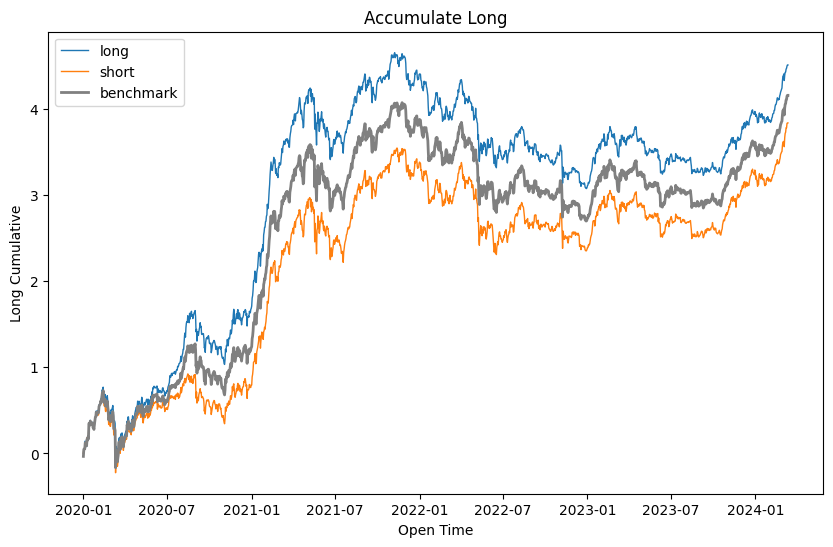

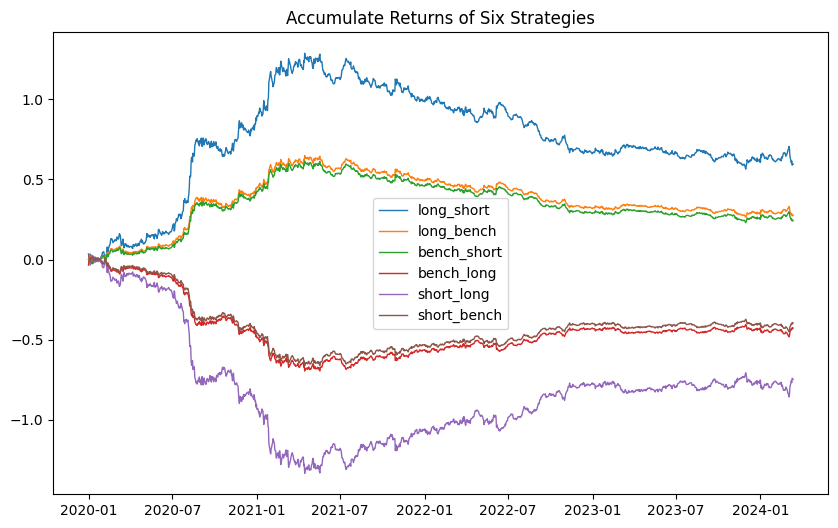

long: 
ann_return = 25.7571  sharpe = 5.5653  maxdd = 0.4902  calmar_ratio = 52.5394  

short: 
ann_return = 21.9163  sharpe = 4.792  maxdd = 0.5433  calmar_ratio = 40.337  

bench: 
ann_return = 23.7448  sharpe = 5.2089  maxdd = 0.5174  calmar_ratio = 45.8928  

long_short: 
ann_return = 3.4028  sharpe = 2.7196  maxdd = 0.3162  calmar_ratio = 10.7625  

long_bench: 
ann_return = 1.5742  sharpe = 2.4614  maxdd = 0.2341  calmar_ratio = 6.7251  

bench_long: 
ann_return = -2.4502  sharpe = -3.8311  maxdd = 0.6992  calmar_ratio = -3.5043  

short_long: 
ann_return = -4.2788  sharpe = -3.4198  maxdd = 1.3275  calmar_ratio = -3.2232  

short_bench: 
ann_return = -2.2666  sharpe = -3.5954  maxdd = 0.6738  calmar_ratio = -3.3639  

bench_short: 
ann_return = 1.3906  sharpe = 2.2058  maxdd = 0.2386  calmar_ratio = 5.8287  



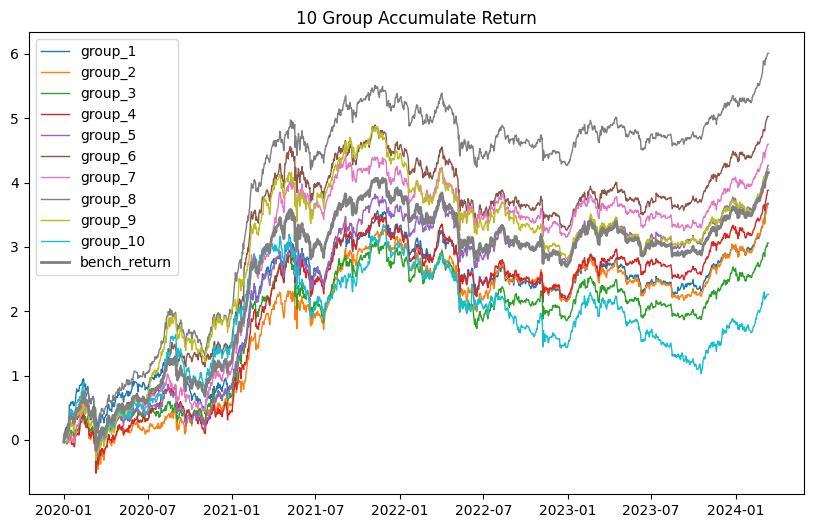

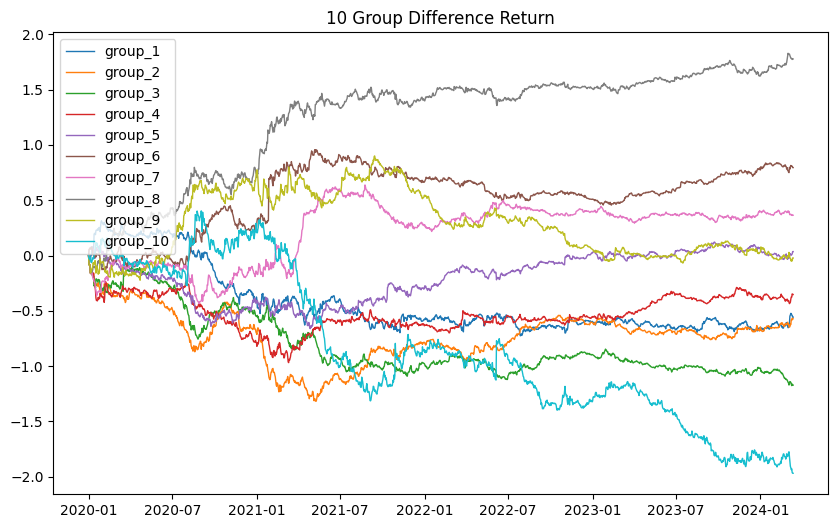

group_1: 
ann_return = 20.9971  sharpe = 4.3772  maxdd = 0.449  calmar_ratio = 46.7635  

group_2: 
ann_return = 20.9156  sharpe = 4.4552  maxdd = 0.6658  calmar_ratio = 31.4137  

group_3: 
ann_return = 17.4868  sharpe = 3.7827  maxdd = 0.5917  calmar_ratio = 29.5544  

group_4: 
ann_return = 22.1692  sharpe = 4.733  maxdd = 0.6517  calmar_ratio = 34.0191  

group_5: 
ann_return = 24.3879  sharpe = 5.1597  maxdd = 0.5825  calmar_ratio = 41.8657  

group_6: 
ann_return = 28.7259  sharpe = 5.9153  maxdd = 0.4892  calmar_ratio = 58.7218  

group_7: 
ann_return = 26.2647  sharpe = 5.5241  maxdd = 0.523  calmar_ratio = 50.2149  

group_8: 
ann_return = 34.3393  sharpe = 7.235  maxdd = 0.4247  calmar_ratio = 80.8582  

group_9: 
ann_return = 24.0593  sharpe = 4.8597  maxdd = 0.5609  calmar_ratio = 42.8963  

group_10: 
ann_return = 12.9347  sharpe = 2.4336  maxdd = 0.5521  calmar_ratio = 23.427  

-----------------------------------------
group_difference_1: 
ann_return = -3.1857  sharpe = 

In [3]:
from factor_analysis.factor_analysis import FactorAnalysis

factors = df.select(['open_time', 'symbol', 'taker_buy_quote_volume_ratio'])

# 使用示例
analysis = FactorAnalysis(factors, data)
analysis.run_full_analysis()